In [140]:
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib.table import table
from sklearn.neighbors import KernelDensity
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import jinja2
import re
import tabulate
import ridgeplot as rg
import nbformat
from sympy import true, false

import seaborn as sns
import plotly.io as pio
pio.renderers.default = "notebook"
from IPython.display import IFrame
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
#Okay, we have our standardized street names. Now we start seeing how many crashes each has.
df = pd.read_csv("2012-24_Crash_Events_std_street_names_dataset.csv")
df = df.dropna(subset=["CaseYear", "CrashDate", "CrashTime"]).copy()

# Ensure CrashDate is datetime
df["CrashDate"] = pd.to_datetime(df["CrashDate"], errors="coerce")

# Prepare CrashHour from CrashTime
df["CrashHour"] = (df["CrashTime"] // 100).astype(int)


/tmp/ipykernel_10269/927982530.py:25: DtypeWarning:

Columns (0: CaseNumber) have mixed types. Specify dtype option on import or set low_memory=False.



In [144]:
df['Serious_and_Fatal_Injuries'] = df['NumberOfFatalities'] + df['NumberOfSeriousInjuries']

pared_df = []

df['OnStreet_standardized'].value_counts()

dropped_df = df[df.OnStreet_standardized != "UNKNOWN"]




In [145]:
#heatmap - fatal/serious injuries per streets and years
freqtb_y = pd.crosstab(dropped_df["Serious_and_Fatal_Injuries"], dropped_df["OnStreet_standardized"])



In [146]:
#top streets by number of serious injuries or deaths
streets = dropped_df["OnStreet_standardized"].unique()
years = dropped_df["CaseYear"].unique()
totalseriousinj = []


for street in streets:
    totalseriousinj.append([street, dropped_df[(dropped_df['OnStreet_standardized']==street)].Serious_and_Fatal_Injuries.sum()])
totalseriousinj


[['STATE ROUTE 104', np.int64(134)],
 ['STATE ROUTE 15A', np.int64(0)],
 ['FIRST STREET', np.int64(4)],
 ['STATE ROUTE 251', np.int64(1)],
 ['SECOND AVENUE', np.int64(0)],
 ['SECOND STREET', np.int64(0)],
 ['STATE ROUTE 31F', np.int64(2)],
 ['STATE ROUTE 33', np.int64(20)],
 ['390', np.int64(0)],
 ['THIRD STREET', np.int64(0)],
 ['STATE ROUTE 441', np.int64(20)],
 ['INTERSTATE 490', np.int64(229)],
 ['FOURTH AVENUE', np.int64(0)],
 ['FOURTH SECTION ROAD', np.int64(20)],
 ['FOURTH STREET', np.int64(1)],
 ['INTERSTATE 590', np.int64(37)],
 ['FIFTH STREET', np.int64(1)],
 ['STATE ROUTE 65', np.int64(2)],
 ['SIXTH STREET', np.int64(0)],
 ['SEVENTH STREET', np.int64(1)],
 ['EIGHTH STREET', np.int64(0)],
 ['9 MILE POINT ROAD', np.int64(0)],
 ['AAB STREET', np.int64(0)],
 ['ABBOT STREET', np.int64(0)],
 ['ABBOTSWOOD CRESCENT', np.int64(0)],
 ['ABBOTT STREET', np.int64(0)],
 ['ABERDEEN STREET', np.int64(0)],
 ['ABINGTON ROAD', np.int64(1)],
 ['ACADEMY DRIVE', np.int64(0)],
 ['ACHILLES STREET',

In [150]:
cols = ['Street', 'Serious_and_Fatal_Injuries']
injframe = pd.DataFrame(totalseriousinj, columns=cols)
injframe.sort_values(by='Serious_and_Fatal_Injuries', inplace=True, ascending=False)
#injframe
top10frame = injframe.head(10)
top10frame




,Street,Serious_and_Fatal_Injuries
11,INTERSTATE 490,229
3133,LAKE AVENUE,213
1592,DEWEY AVENUE,161
0,STATE ROUTE 104,134
5840,WEST RIDGE ROAD,115
3447,LYELL AVENUE,107
1058,CHILI AVENUE,101
2797,HUDSON AVENUE,94
1136,CLIFFORD AVENUE,92
5269,STATE ROUTE 390,90


In [158]:
top10streets = top10frame["Street"].unique()
top10streets

annualframe = dropped_df[dropped_df["OnStreet_standardized"].isin(top10streets)]
annualframe


,CaseNumber,CaseYear,CrashDate,CrashTime,CrashTimeFormatted,CrashTypeCde,CrashType,CollisionType,CrashSeverity,LightCondition,...,DriverAgeVehicleThree,DriverAgeVehicleFour,DriverAgeVehicleFive,PersonTypes,PersonInjuries,ApparentFactors,ApparentFactorCodes,OnStreet_standardized,CrashHour,Serious_and_Fatal_Injuries
0,36996805,2017,2017-11-22,2353.0,11:53 PM,7,COLLISION WITH DEER,OTHER,PROPERTY DAMAGE,DARK-ROAD UNLIGHTED,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(ANIMALS ACTION,NOT APPLICABLE)",|61|777|,STATE ROUTE 104,23,0
1,37791267,2019,2019-02-20,615.0,6:15 AM,7,COLLISION WITH DEER,OTHER,PROPERTY DAMAGE,DAWN,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(NOT ENTERED,NOT ENTERED)",|888|888|,STATE ROUTE 104,6,0
2,37328049,2018,2018-06-04,723.0,7:23 AM,1,COLLISION WITH MOTOR VEHICLE,OTHER,PROPERTY DAMAGE,DAYLIGHT,...,0.0,NaN,NaN,U1:(DRIVER) / U2:(DRIVER) / U3:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN) / U3:(U - ...,"V1:(FOLLOWING TOO CLOSELY,NOT APPLICABLE) / V2...",|9|777|777|777|777|777|,STATE ROUTE 104,7,0
3,36064247,2016,2016-01-18,2305.0,11:05 PM,14,COLLISION WITH SIGN POST,OTHER,PROPERTY DAMAGE,DARK-ROAD LIGHTED,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(PAVEMENT SLIPPERY,UNSAFE SPEED)",|66|19|,STATE ROUTE 104,23,0
4,36593945,2017,2017-01-08,0.0,12:00 AM,12,COLLISION WITH GUIDE RAIL,OTHER,PROPERTY DAMAGE,UNKNOWN,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(NOT ENTERED,NOT ENTERED)",|888|888|,STATE ROUTE 104,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287158,38348616,2020,2020-01-11,1630.0,4:30 PM,1,COLLISION WITH MOTOR VEHICLE,OVERTAKING,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(NOT APPLICABLE,NOT APPLICABLE) / V2:(FAILU...",|777|777|7|20|,STATE ROUTE 390,16,0
287159,34322472,2012,2012-05-16,730.0,7:30 AM,1,COLLISION WITH MOTOR VEHICLE,OVERTAKING,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(PASSING OR LANE USAGE IMPROPERLY,AGGRESSIV...",|13|28|777|777|,STATE ROUTE 390,7,0
287160,35976507,2015,2015-11-16,1753.0,5:53 PM,1,COLLISION WITH MOTOR VEHICLE,REAR END,PROPERTY DAMAGE,DARK-ROAD LIGHTED,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(FOLLOWING TOO CLOSELY,NOT APPLICABLE) / V2...",|9|777|777|777|,STATE ROUTE 390,17,0
287161,35085244,2014,2014-01-01,1554.0,3:54 PM,12,COLLISION WITH GUIDE RAIL,OTHER,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(UNSAFE SPEED,PAVEMENT SLIPPERY)",|19|66|,STATE ROUTE 390,15,0


CaseYear               2012  2013  2014  2015  2016  2017  2018  2019  2020  \
OnStreet_standardized                                                         
CHILI AVENUE             15     6     5     8     5     7     9    12     5   
CLIFFORD AVENUE           6     1     9    11     7     4     8    17     5   
DEWEY AVENUE             10    12    10     7     9     9    12    18    22   
HUDSON AVENUE             2     4     5    12     4     7     4     6     8   
INTERSTATE 490           16    14    15    14    11    18    22     8    13   
LAKE AVENUE              11    10    10     9    18    14    14    11    26   
LYELL AVENUE              6     3     5     4     9     5    14    10     7   
STATE ROUTE 104          12     6    10    15     8     7    10    17     8   
STATE ROUTE 390           3     8     7     7     6     6    11    12     3   
WEST RIDGE ROAD           7    10     9     5     4     9    11     9    13   

CaseYear               2021  2022  2023  2024  
OnS

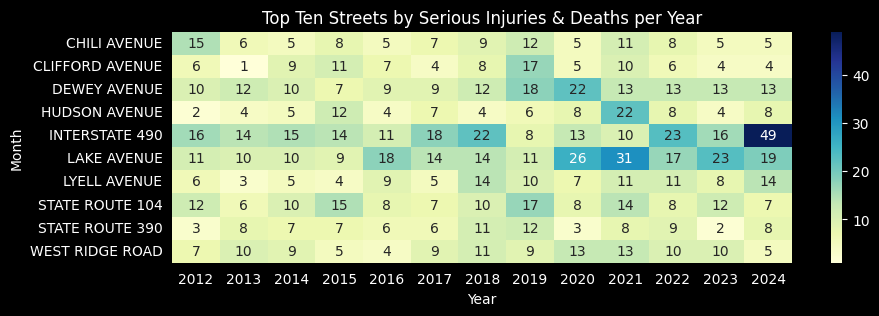

In [168]:
cper_m_per_y = pd.crosstab(
    annualframe["OnStreet_standardized"],
    annualframe["CrashDate"].dt.year,
)
annualframe_pivot = pd.pivot_table(annualframe, index="OnStreet_standardized",columns="CaseYear",values="Serious_and_Fatal_Injuries", aggfunc="sum")
print(annualframe_pivot)
plt.figure(figsize=(10, 3))
sns.heatmap(annualframe_pivot, annot=True, cmap="YlGnBu")
plt.title("Top Ten Streets by Serious Injuries & Deaths per Year")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Year")
plt.ylabel("Month")

# Save figure as PDF
#pdf_file = "Crashes_per_Month_per_Year.pdf"
#plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

CrashMonth             1   2   3   4   5   6   7   8   9   10  11  12
OnStreet_standardized                                                
CHILI AVENUE            6   7   5   6  13   9  12  10   5   6  13   9
CLIFFORD AVENUE         1   6   4   5   5  20  14   9   8  11   6   3
DEWEY AVENUE            5   4  12  16  16  11  16  14  18  13  22  14
HUDSON AVENUE          12   3   9   4   9   4  14   8  11   7   6   7
INTERSTATE 490         19  23   9  13  19  24  21  17  14  19  35  16
LAKE AVENUE            18  17  21  13  17  17  20  20  15  20  16  19
LYELL AVENUE           11  10   9   7   5  10   9   6  10  13  13   4
STATE ROUTE 104         9  13   9  14  15  14   8  16  10  15   5   6
STATE ROUTE 390         4   9   5   7   9   6   9   8   5  16   8   4
WEST RIDGE ROAD         5  11   9   8   5   8  13  15  17   9   9   6


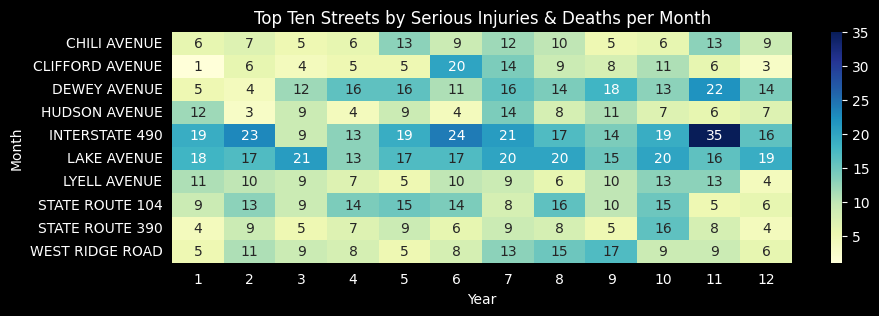

In [169]:
annualframe['CrashMonth'] = annualframe['CrashDate'].dt.month
annualframe_pivot = pd.pivot_table(annualframe, index="OnStreet_standardized",columns="CrashMonth",values="Serious_and_Fatal_Injuries", aggfunc="sum")
print(annualframe_pivot)
plt.figure(figsize=(10, 3))
sns.heatmap(annualframe_pivot, annot=True, cmap="YlGnBu")
plt.title("Top Ten Streets by Serious Injuries & Deaths per Month")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Year")
plt.ylabel("Month")

# Save figure as PDF
#pdf_file = "Crashes_per_Month_per_Year.pdf"
#plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

In [148]:
streets = dropped_df["OnStreet_standardized"].unique()
years = dropped_df["CaseYear"].unique()
totalseriousinj_yearly = []


# Note - not sure how to efficiently select both year and date...
df = df.sort_values('CaseYear')
years.sort()
print(years)
df

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


,CaseNumber,CaseYear,CrashDate,CrashTime,CrashTimeFormatted,CrashTypeCde,CrashType,CollisionType,CrashSeverity,LightCondition,...,DriverAgeVehicleThree,DriverAgeVehicleFour,DriverAgeVehicleFive,PersonTypes,PersonInjuries,ApparentFactors,ApparentFactorCodes,OnStreet_standardized,CrashHour,Serious_and_Fatal_Injuries
121239,34340109,2012,2012-06-21,851.0,8:51 AM,1,COLLISION WITH MOTOR VEHICLE,REAR END,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(UNKNOWN,NOT APPLICABLE) / V2:(UNKNOWN,NOT ...",|999|777|999|777|,JEFFERSON ROAD,8,0
132007,34399825,2012,2012-07-04,2330.0,11:30 PM,2,COLLISION WITH PEDESTRIAN,OTHER,INJURY,DARK-ROAD LIGHTED,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(NOT APPLICABLE,NOT APPLICABLE)",|777|777|,LAKE AVENUE,23,0
261799,34435158,2012,2012-09-07,1647.0,4:47 PM,1,COLLISION WITH MOTOR VEHICLE,REAR END,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(DRIVER INATTENTION,FOLLOWING TOO CLOSELY) ...",|4|9|777|777|,WEST MAIN STREET,16,0
261763,34392213,2012,2012-08-06,1519.0,3:19 PM,1,COLLISION WITH MOTOR VEHICLE,HEAD ON,INJURY,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(FAILURE TO YIELD RIGHT OF WAY,DRIVER INATT...",|7|4|4|777|,WEST MAIN STREET,15,0
261766,34218088,2012,2012-02-25,1310.0,1:10 PM,2,COLLISION WITH PEDESTRIAN,OTHER,INJURY,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(NOT APPLICABLE,NOT APPLICABLE)",|777|777|,WEST MAIN STREET,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31386,40471213,2024,2024-09-06,2307.0,23:07:00,17,COLLISION WITH CURBING,OTHER,PROPERTY DAMAGE,DARK-ROAD LIGHTED,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(UNSAFE SPEED,FAILURE TO KEEP RIGHT)",|19|27|,CHILI AVENUE,23,0
31369,40487512,2024,2024-09-22,1545.0,15:45:00,1,COLLISION WITH MOTOR VEHICLE,UNKNOWN,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,,,"V1:(BACKING UNSAFELY,UNKNOWN) / V2:(NOT APPLIC...",|3|999|777|777|,CHILI AVENUE,15,0
31370,40487510,2024,2024-09-24,747.0,07:47:00,1,COLLISION WITH MOTOR VEHICLE,REAR END,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U2:(DRIVER),U2:(U - UNKNOWN),"V1:(DRIVER INATTENTION,UNSAFE SPEED) / V2:(UNK...",|4|19|999|777|,CHILI AVENUE,7,0
145028,40560087,2024,2024-11-13,1420.0,14:20:00,1,COLLISION WITH MOTOR VEHICLE,OTHER,PROPERTY DAMAGE,DAYLIGHT,...,0.0,NaN,NaN,U1:(DRIVER) / U2:(DRIVER) / U3:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN) / U3:(U - ...,"V1:(UNSAFE SPEED,DRIVER INATTENTION) / V2:(FAI...",|19|4|7|777|777|777|,LONG POND ROAD,14,0


In [122]:
for year in years:
    print(year)
    year_df = dropped_df.loc[dropped_df['CaseYear'] == year]
    for street in streets:
        totalseriousinj_yearly.append([year, street, year_df[(dropped_df['OnStreet_standardized']==street)].Serious_and_Fatal_Injuries.sum()])
cols = ['CaseYear', 'OnStreet', 'Serious_and_Fatal_Injuries']
injframe_yearly = pd.DataFrame(totalseriousinj_yearly, columns=cols)
injframe_yearly.to_csv('yearlyseriousdeaths.csv', index=False)
#Code to generate sums of streets by year. Don't run unless you have to. It takes 20 minutes.

In [123]:

injframe_yearly = pd.read_csv("yearlyseriousdeaths.csv")

injframe_yearly[injframe_yearly['OnStreet'] == 'STATE ROUTE 104']


,CaseYear,OnStreet,Serious_and_Fatal_Injuries
0,2012,STATE ROUTE 104,12
6330,2013,STATE ROUTE 104,6
12660,2014,STATE ROUTE 104,10
18990,2015,STATE ROUTE 104,15
25320,2016,STATE ROUTE 104,8
31650,2017,STATE ROUTE 104,7
37980,2018,STATE ROUTE 104,10
44310,2019,STATE ROUTE 104,17
50640,2020,STATE ROUTE 104,8
56970,2021,STATE ROUTE 104,14


In [170]:
injframe_yearly



for year in years:
    top_2012 = injframe_yearly[injframe_yearly['CaseYear'] == year]
    top_2012=top_2012.sort_values('Serious_and_Fatal_Injuries', ascending=False)
    top = top_2012.head(15)
    name = 'annualcrashlists/'
    name += str(year)
    name += '_top15streetsseriousdeaths.csv'

    top.to_csv(name, index=False)
